In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import pystan
import seaborn as sns
import arviz
%matplotlib inline

In [2]:
df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
df = df.dropna().reset_index(drop=True)

In [3]:
df.head()

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,1,108641,303.14
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,1,80272,6442.44
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,83,17.9,1,303691,76.94
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,65,74.9,1,92122,1516.63
4,Australia,24992369,86.012,51663.365095,7.608913e+06,8.62,9.160533,8.07,26,97.3,1,1347,75667.65


# 階層ベイズモデル

In [4]:
# 必要な変数の抽出
X = df[["date_first", "hf", "pop", "urb", "dist", "air"]]
# 全て対数化
X = np.log(X)
# indexを追加(国ごとの差を表現するindex)
X = X.reset_index()
X["index"] = X["index"] +1

X.head()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,index,date_first,hf,pop,urb,dist,air
0,1,4.248495,2.059239,14.868559,4.099647,15.760924,5.714195
1,2,4.060443,1.607436,17.558604,4.285364,16.024694,8.770663
2,3,4.418841,1.686399,17.243342,4.182264,16.165944,4.343026
3,4,4.174387,1.925707,17.610876,4.520375,16.761297,7.324246
4,5,3.258097,2.154085,17.034081,4.454487,15.844831,11.234106


In [5]:
X["index"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150])

In [35]:
stan_model = """
data {
    int N;
    int N_country;
    real hf[N];
    real pop[N];
    real urb[N];
    real dist[N];
    real air[N];
    real Y[N];
    int<lower=1, upper=150> index[N];
    int<lower=0> N_new;
}

parameters {
    real k0;
    real k_country[N_country];
    real<lower=0> s_k; 
    
    real h;
    real p;
    real u;
    real d;
    real a;
    real b;
    real<lower=0> sigma; 
}

transformed parameters{
    real k[N_country];

    for (n in 1:N_country){
        k[n] = k0 + k_country[n];
    }    
}


model{
    for (country in 1:N_country){
        k_country[country] ~ normal (0,s_k);
    }
    
    for (n in 1:N){
        Y[n] ~ normal(h * hf[n] + p * pop[n] + u * urb[n] + d * dist[n] + a * air[n] + b + k[index[n]], sigma);
    }
}

generated quantities {
    real Y_new[N_new];
    real mu_new;
    for (n in 1:N_new){
        mu_new = h * hf[n] + p * pop[n] + u * urb[n] + d * dist[n] + a * air[n] + b + k[index[n]];
        Y_new[n] = normal_rng(mu_new, sigma);
    }
}
"""

In [ ]:
    for (country in 1:N_country){
        k_country[country] ~ normal (0,s_k);
    }

In [36]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8208f24f044b190cdb7c99ea74219a5d NOW.


In [37]:
stan_data = {
    "N":X.shape[0],
    "N_country":X.shape[0],
    "hf":X["hf"],
    "pop":X["pop"],
    "urb":X["urb"],
    "dist":X["dist"],
    "air":X["air"],
    "Y":X["date_first"],
    "index":X["index"],
    "N_new":X.shape[0],
}

In [38]:
fit = sm.sampling(data=stan_data, iter=1000, warmup=300, chains=4, seed=123)

In [39]:
print(fit)

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


Inference for Stan model: anon_model_8208f24f044b190cdb7c99ea74219a5d.
4 chains, each with iter=1000; warmup=300; thin=1; 
post-warmup draws per chain=700, total post-warmup draws=2800.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
k0               55.5    70.1 108.71 -44.84  -27.0  26.77  43.18 314.05      2    6.5
k_country[1]     5.78    8.46  14.35  -8.34  -1.81  -0.16   3.73  42.45      3    2.2
k_country[2]    -3.09    8.09  13.95 -35.14  -6.96  -1.54   4.87  20.26      3   2.22
k_country[3]    -2.91    3.73    8.4 -25.22  -6.32  -3.15   3.18   9.45      5   1.49
k_country[4]    -2.19    0.68    6.5  -20.3  -4.44  -0.86  -0.25  10.94     90    1.1
k_country[5]      4.8    9.11  14.84  -11.5  -2.74   0.57   2.66  43.11      3   3.27
k_country[6]     8.52   10.96  17.63  -5.12  -2.25   0.37   8.08  53.33      3   2.52
k_country[7]     4.15    4.41   9.78  -4.36  -2.54   1.49   5.97  35.23      5   1.39
k_country[8]     0.52    5.43  13.05  -

In [40]:
"""with open('output1027.txt', 'w') as f:
    print(fit, file=f)"""

"with open('output1027.txt', 'w') as f:\n    print(fit, file=f)"

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (460), generating only 20 plots
  UserWarning,


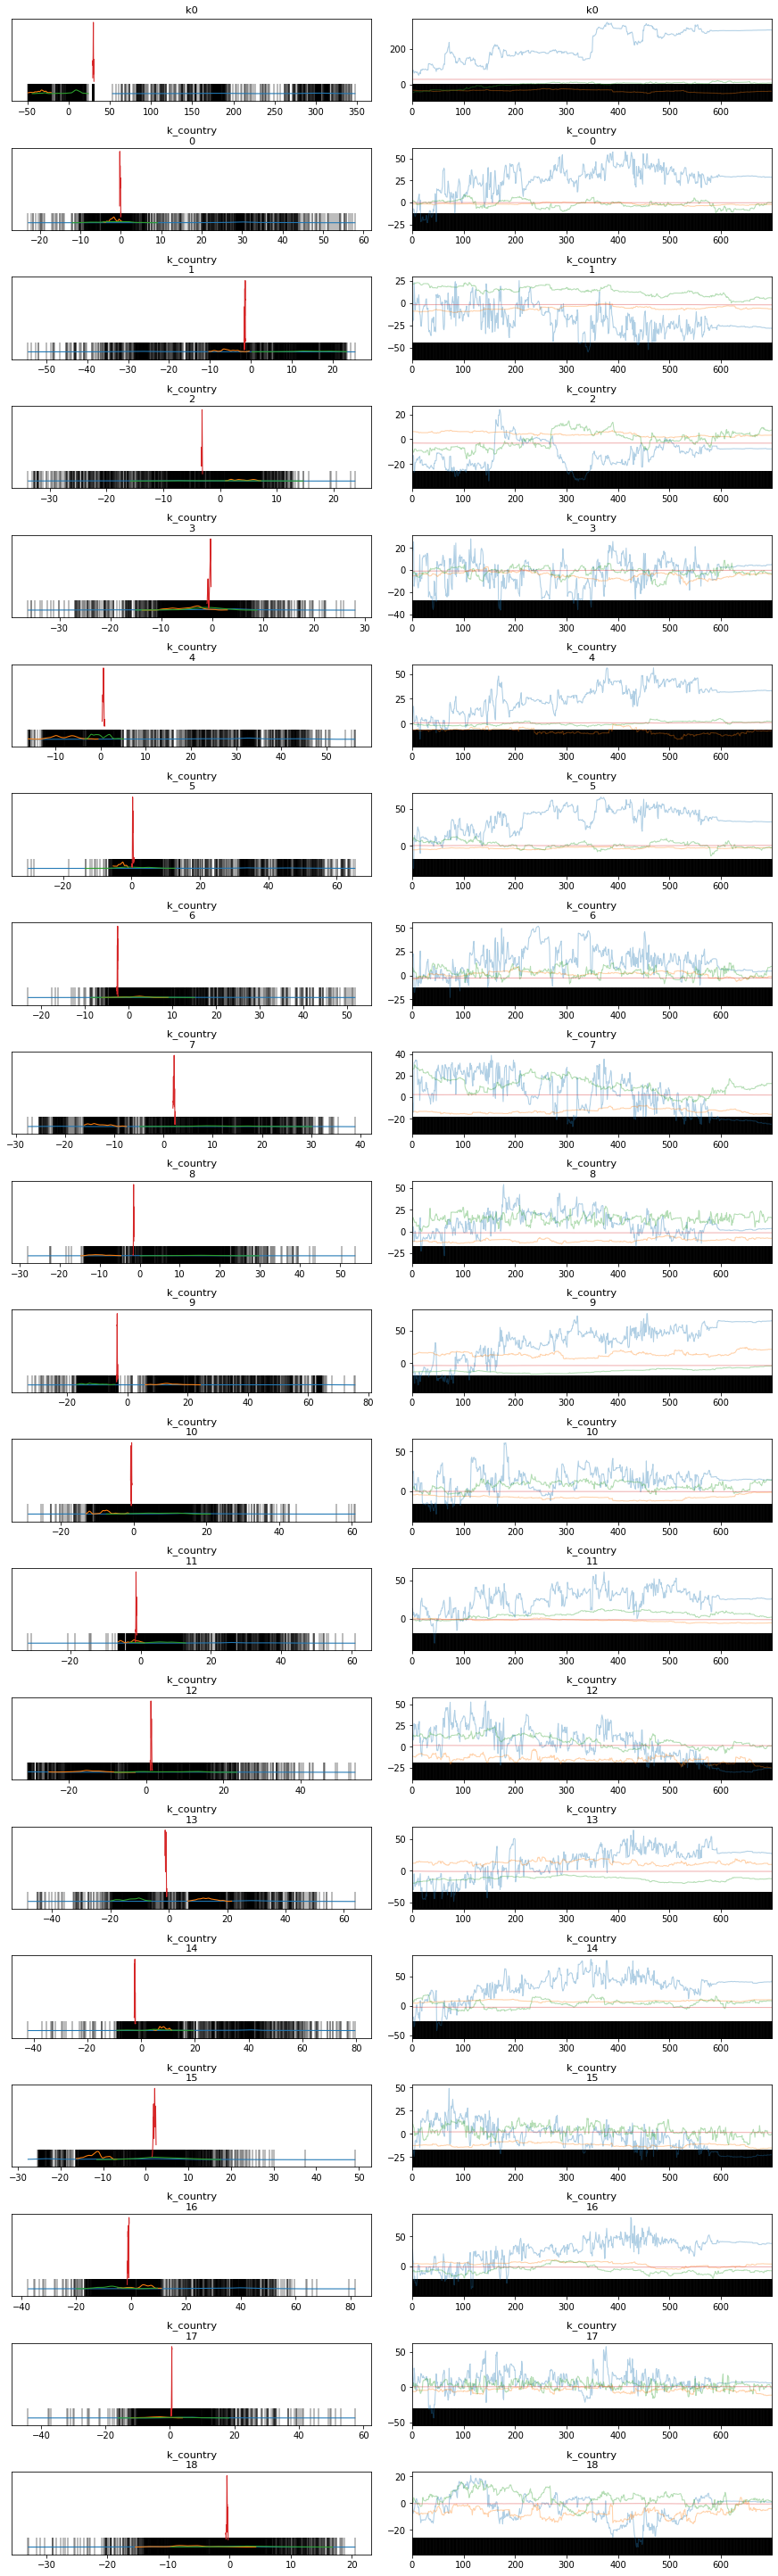

In [41]:
arviz.plot_trace(fit)
plt.show()

In [26]:
"""axes = arviz.plot_trace(fit)
fig = axes.ravel()[0].figure
fig.savefig("bayes1027.png")"""

'axes = arviz.plot_trace(fit)\nfig = axes.ravel()[0].figure\nfig.savefig("bayes1027.png")'

- mersのデータと比較(説明変数の影響度の)    
- うまい結果が出れば、国ごとの個性を活用。クラスタリング    
- pymc、データから自動的にアルゴリズムが選ばれる??  
  
  
- 背景知識  
- ドメイン、ウイルスの流行、COVID-19  
- 過去のウイルス(過去のことで何がわかっているか、covid19と比較) 
- 平均